In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Chemin vers la base de données

data_dir = '/content/drive/MyDrive/Mask_Data'

In [ ]:
ls

Partie 1 : Base de données, Analyse et Préparation

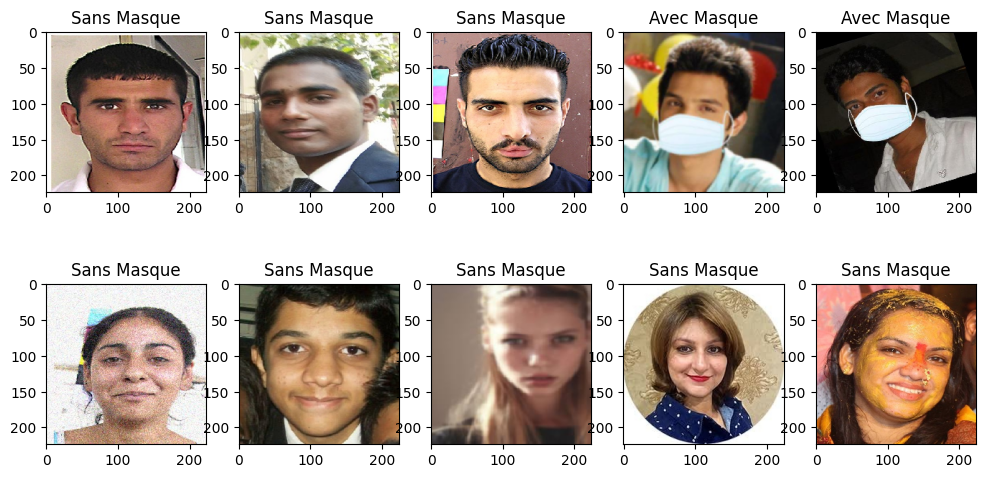

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Spécifiez les chemins vers les dossiers "with_mask" et "without_mask"
with_mask_dir = "/content/drive/MyDrive/Mask_Data/with_mask"
without_mask_dir = "/content/drive/MyDrive/Mask_Data/without_mask"


# Fonction pour charger les images depuis un dossier
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(224, 224))
        img = img_to_array(img)
        images.append(img)
    return images, [label] * len(images)

# Chargez les images et étiquetez-les
images_with_mask, labels_with_mask = load_images_from_folder(with_mask_dir, 1)
images_without_mask, labels_without_mask = load_images_from_folder(without_mask_dir, 0)

# Concaténez les données et les étiquettes
images = np.array(images_with_mask + images_without_mask)
labels = np.array(labels_with_mask + labels_without_mask)

# Divisez les donnée en ensembles d'apprentissage et de validation
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Visualisez
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
random_indices = random.sample(range(len(X_train)), 10)
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].astype('uint8'))
    if y_train[idx] == 1:
        plt.title('Avec Masque')
    else:
        plt.title('Sans Masque')
plt.show()

Partie 2 : Architecture CNN sur Keras

Found 1207 images belonging to 2 classes.
Found 301 images belonging to 2 classes.
Epoch 1/10
38/38 [==============================] - 43s 1s/step - loss: 0.6995 - accuracy: 0.4838 - val_loss: 0.6867 - val_accuracy: 0.5017
Epoch 2/10
38/38 [==============================] - 31s 799ms/step - loss: 0.5590 - accuracy: 0.6810 - val_loss: 0.4764 - val_accuracy: 0.8405
Epoch 3/10
38/38 [==============================] - 31s 806ms/step - loss: 0.1699 - accuracy: 0.9420 - val_loss: 0.1486 - val_accuracy: 0.9568
Epoch 4/10
38/38 [==============================] - 31s 809ms/step - loss: 0.0619 - accuracy: 0.9834 - val_loss: 0.0382 - val_accuracy: 0.9900
Epoch 5/10
38/38 [==============================] - 31s 797ms/step - loss: 0.0888 - accuracy: 0.9768 - val_loss: 0.0461 - val_accuracy: 0.9834
Epoch 6/10
38/38 [==============================] - 31s 803ms/step - loss: 0.0284 - accuracy: 0.9901 - val_loss: 0.0215 - val_accuracy: 0.9900
Epoch 7/10
38/38 [==============================] - 30s 786ms/

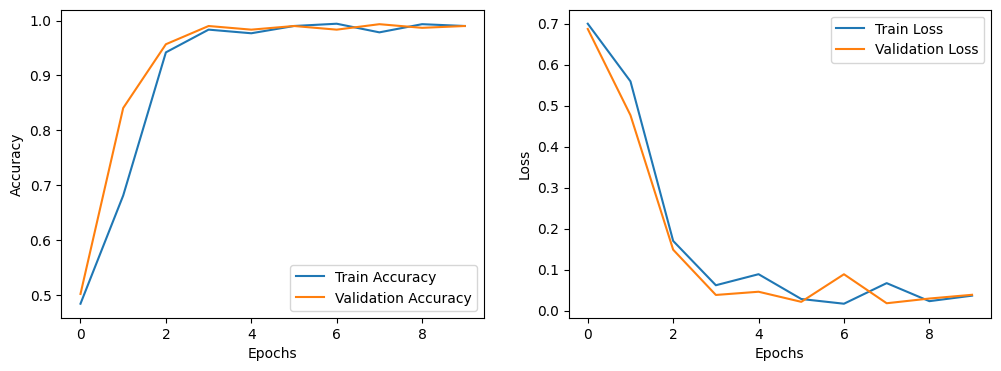

In [ ]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2

# Définition des paramètres
img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.20
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajout de la couche de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Définition de ModelCheckpoint pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Entraînement du modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Tracé des courbes d'accuracy et de loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Évaluation du modèle sur les données de test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

model.load_weights("best_model.h5")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

Partie 3 : Application

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Chargez le modèle pré-entraîné
model = load_model("best_model.h5")

# Démarrez la capture vidéo
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Retournez horizontalement l'image
    frame = cv2.flip(frame, 1)

    # Redimensionnez l'image
    img = cv2.resize(frame, (224, 224))

    # Prétraitez l'image
    img = img / 255.0

    # Passez l'image au modèle pour obtenir une prédiction
    prediction = model.predict(np.expand_dims(img, axis=0))[0]

    # Obtenez l'indice de la classe avec la probabilité maximale
    predicted_class_index = np.argmax(prediction)

    # Déterminez la classe prédite en fonction de l'indice
    if predicted_class_index == 0:
        label = "Sans Masque"
    else:
        label = "Avec Masque"

    # Affichez sur l'image
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Affichez la vidéo
    cv2.imshow("Webcam", frame)

    # Quittez q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérez les ressources
cap.release()
cv2.destroyAllWindows()
